# World Data League 2021 🚲

**Sub:** Predicting the demand for shared bicycles in Medellín, CO<br>
**Team:** NextEpoch

## Notebook Template (WDL content)

This notebook is one of the mandatory deliverables when you submit your solution (alongside the video pitch). Its structure follows the WDL evaluation criteria and it has dedicated cells where you can add descriptions. Make sure your code is readable as it will be the only technical support the jury will have to evaluate your work.
The notebook must:
*   💻 have all the code that you want the jury to evaluate
*   🧱 follow the predefined structure
*   📄 have markdown descriptions where you find necessary
*   👀 be saved with all the output that you want the jury to see
*   🏃‍♂️ be runnable

## External links and resources 🔗

All used data was acquired through the following links:

1. Metro link: https://wdl-data.fra1.digitaloceanspaces.com/medellin/medellin_metro_stations_and_routes.zip
2. Bike load csv: https://wdl-data.fra1.digitaloceanspaces.com/medellin/bike_loans.zip
3. Bus routes: https://wdl-data.fra1.digitaloceanspaces.com/medellin/medellin_bus_routes.zip
4. Weather API: https://openweathermap.org/history
5. HERE API Route calculation: https://route.ls.hereapi.com/routing/7.2/calculateroute.json
6. Climate of Medellin: https://en.wikipedia.org/wiki/Medell%C3%ADn#Climate
7. Academic holiday info of Medellin: https://www.mineducacion.gov.co/1759/articles-402903_m_07.pdf

## Introduction 👩‍🏫

**Overview:**
During this 2-week’s sprint we are working on historical bike rental data from the provider 'EnCicla' in Medellin, Colombia. The company is government owned and provides over 1,600 bicycles distributed in over 101 stations in Medellin and its greater area. The bike rental is for free for everyone who is registered in the system. However, it has operating hours at which the rentals are permitted, usually between 5am to 10pm. Additionally, on Sundays it seems that EnCicla does not run.

_from challenge description_
<blockquote>
One of the main challenges that the system has is to keep bicycles available by the time the user approaches the station to make a loan and have anchor points available for the moment the user wants to deliver the borrowed bike.
</blockquote>

The heart of the provided **data** is a transaction log for each bike pick-up and drop-off since 2014. In total there are aprox. 14m rows in the data set. One of the main challenges is to preprocess the data and make it usable for a system balance prediction model. The data includes pre and post covid rentals. 

We decided to narrow it down to a pre-covid analysis because we assumed that the data would be more appropriate in trying to predict future post-covid trends. 

In our project, we:

* Extracted the information
* Explored & Visualized the data
* Preprocessed & Feature Engineered
* Developed Time-Series Model to predict demand per station 

**Research:**

EnCicla is a public bicycle renting service in Medellín, Colombia, which began in 2011. It is one of two the public bike sharing programs in Colombia and was the first such program created in Latin America. It is part of the Aburrá Valley Integrated Transport System (Sistema Integrado de Transporte del Valle de Aburrá, SITVA).

To start using Encicla, you just need to go to an Encicla station and take your first bike. However, you need to know that there are two different types of stations: **manual and automatic**. On the manual stations, there is an Encicla employee to whom you need to show your cívica card. On the automatic stations, you need to place your card over the electronic totem to unblock it.
When you already have the bike with you, you have 1 hour to use it. In case you need more time, you can renew the rent in any of the Encicla stations of Medellin.

**Monday to Friday:** 
* 5:30 am to 10:00 pm
* Last loan: 9:00 pm

**Saturday:**
* 6:30 am to 9:00 pm

**Special Stations:**
However, there is a special schedule for the Cisneros, Unaula and Museo de Antioquia stations: on Monday to Friday from 5:30 a.m to 5:30 p.m for rent and reception and it is the normal schedule on Sunday.

## Development ⚙️

### Imports (libraries) 📚

In [1]:
## TABULAR
import pandas as pd 
import numpy as np
import matplotlib

## GEO
import geopandas as gpd
import fiona
import folium
from folium.plugins import MarkerCluster, HeatMap, BeautifyIcon
from folium.map import LayerControl, Layer, FeatureGroup
from folium.vector_layers import Circle, CircleMarker
from shapely.geometry import LineString, Point
from shapely import wkt


## DATA
import os
import zipfile
from collections import Counter
import re
from datetime import datetime
import requests
from dotenv import load_dotenv, find_dotenv
import ast
import datetime as dt

## VIS
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.tsa
import branca

### Data Extraction 🏗

The provided data comes in different types of file extensions.  <br> 
Some of the files are **very big** and for this reason is easier to call them just when we need them. <br>
For this reason we are going to create a class that will be able to read and extract the data, already operating the first **cleaning** steps.

In [2]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' # necessary for kml files
class Databases:
    def __init__(self, csv, anva, smm, metro): # pass the file names stored in 'raw_data/'
        self.csv = csv
        self.anva = anva 
        self.smm = smm
        self.metro = metro

    def extract_csv(self):
        # bike rental logs
        file = pd.read_csv(f'data/bike_loans/{self.csv}', sep=';').drop(columns=['Importe', 
                                                                        'DescripcionImporte', 
                                                                        'operario']) # drop irrelevant columns
        file['Fecha_Prestamo'] = pd.to_datetime(file['Fecha_Prestamo'])
        file['Fecha_Devolucion'] = pd.to_datetime(file['Fecha_Devolucion'])
        return file
        
    
    def extract_anva(self):
        # regional bus routes
        bus_routes_AMVA = gpd.GeoDataFrame()
        for root, dirs, files in os.walk(f'data/bus_routes/medellin_bus_routes/{self.anva}'):
            for file in files:
                path = os.path.join(root, file)
                df = gpd.read_file(path, driver='KML')
                bus_routes_AMVA = gpd.GeoDataFrame(pd.concat([bus_routes_AMVA, df], ignore_index=True))
        return bus_routes_AMVA
    
    def extract_smm(self):
        # municipal bus routes medellin
        smm_bus_routes = gpd.GeoDataFrame()
        for root, dirs, files in os.walk(f'data/bus_routes/medellin_bus_routes/{self.smm}'):
            for file in files:
                path = os.path.join(root, file)
                df = gpd.read_file(path, driver='KML')
                smm_bus_routes = gpd.GeoDataFrame(pd.concat([smm_bus_routes, df], ignore_index=True))
        return smm_bus_routes
    
    def extract_metro(self):
        # metro routes
        metro_routes = gpd.GeoDataFrame()
        for root, dirs, files in os.walk(f'data/medellin_metro/{self.metro}'):
            for file in files:
                path = os.path.join(root, file)
                print(path)
                if path.endswith('.kmz'):
                    kmz = zipfile.ZipFile(path, 'r')
                    kml = kmz.open('doc.kml', 'r')
                    df = gpd.read_file(kml, driver='KML')
                    metro_routes = gpd.GeoDataFrame(pd.concat([metro_routes, df], ignore_index=True))
        return metro_routes

In [3]:
databases = Databases('bike_loans.csv','Kml Ruta AMVA','kml Ruta SMM','medellin_metro_stations')

In [4]:
bikes = databases.extract_csv() # for our preliminary analysis we only need the bike logs (no public transportation)
bikes.dtypes

Id_Historico_Prestamo               int64
Id_Usuario                          int64
Id_Tag_Bicicleta                   object
Fecha_Prestamo             datetime64[ns]
Fecha_Devolucion           datetime64[ns]
Id_Aparcamiento_Origen              int64
Posicion_Origen                     int64
Id_Aparcamiento_Destino           float64
Posicion_Destino                  float64
Num_Bici_Hist                     float64
dtype: object

### Preliminary Analysis 📊

We can start our analy|sis with a general description of the dataset. <br>
**NB**: In our dataset we are dealing with all categorical features or timeseries: there is no need to run ```describe()``` 

#### Bike usage

- Id_Tag_Bicicleta : column regarding unique id of each bicycle 
***let's have a look on how many times the same bike is used (how many times the unique id is present in the df)**

In [5]:
# sunday EnCicla is closed
bikes.Fecha_Prestamo.dt.weekday.value_counts()

1    2776075
2    2774889
3    2737945
4    2648630
0    2221272
5    1066059
6        485
Name: Fecha_Prestamo, dtype: int64

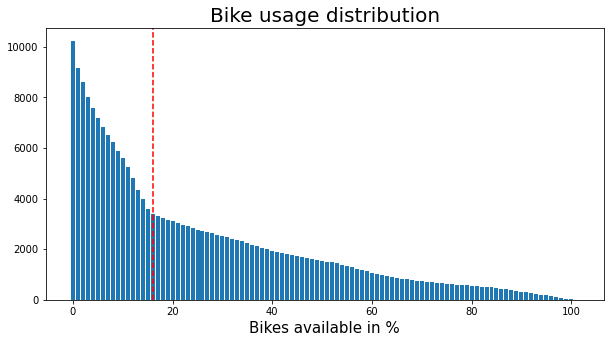

In [6]:
# plot the usage of unique bikes and its distribution
plt.figure(figsize=(10,5))
plt.title('Bike usage distribution', size=20)
counts = bikes.Id_Tag_Bicicleta.value_counts()[::66]
y_pos = np.arange(len(counts))
plt.bar(y_pos, counts)
plt.xlabel('Bikes available in %', size=15)
# plt.text(x=22, y=6000, s=f'Cutoff: 20% of highest usage', size='x-large')
plt.axvline(16, color='r', linestyle='--')

plt.show()

**Note**<br>
There is a strong elbow visible between the 10th and 20th percentile. This could either derive from a highly rising bike usage over the years and thus, underrepresented usage for depreciated bikes. It could also mean that some bikes are significantly standing around too much because they are put to the wrong stations at wrong times and therefore not used enough. 

In [7]:
print(f'In total we have {len(bikes.Id_Tag_Bicicleta.unique())} unique bikes over all recorded time')

In total we have 6698 unique bikes over all recorded time


#### Rental distribution

In our dataset we have information about the bike itself, the station of arrival and departures and the costumer. To characterized all this information we have also 2 time series: ```Fecha_Prestamo``` & ```Fecha_Devolucion``` 

<br>
Thanks to these we can have an idea of the time in which the bike are more used, which routes are more popular during a certain range of time and also how the data collected has changed during the years, according maybe to the change in habits of the population. 

In [8]:
# Extracting just the hour: 
bikes['hour_init']= bikes['Fecha_Prestamo'].dt.hour
bikes['hour_end']=bikes['Fecha_Devolucion'].dt.hour
bikes.head(5)

,Id_Historico_Prestamo,Id_Usuario,Id_Tag_Bicicleta,Fecha_Prestamo,Fecha_Devolucion,Id_Aparcamiento_Origen,Posicion_Origen,Id_Aparcamiento_Destino,Posicion_Destino,Num_Bici_Hist,hour_init,hour_end
0,6501462,18701,000017B00743,2017-06-21 14:22:11,2017-06-21 14:38:29,8,1,43.0,1.0,929.0,14,14
1,6501318,41811,000017AFF83C,2017-06-21 14:07:18,2017-06-21 14:39:06,56,6,54.0,NaN,1612.0,14,14
2,6501489,96620,000017AFFB6F,2017-06-21 14:25:11,2017-06-21 14:39:07,36,25,9.0,13.0,1679.0,14,14
3,6501001,16055,0000182A3B7B,2017-06-21 13:35:52,2017-06-21 14:39:22,8,1,9.0,6.0,1076.0,13,14
4,6501421,6431,000017AFE810,2017-06-21 14:17:56,2017-06-21 14:39:26,56,14,54.0,NaN,1176.0,14,14


/home/sisto/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


The highest usage of bikes is at 17h and 7h


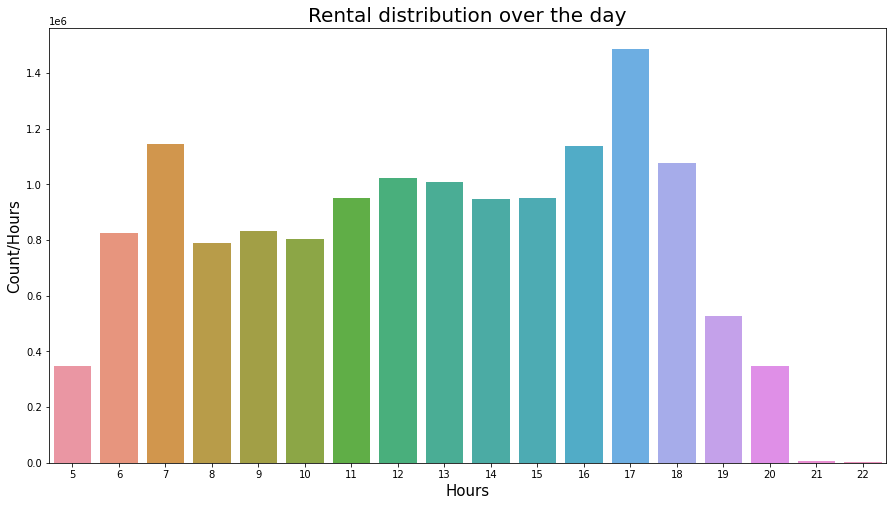

In [9]:
# plot the mean distribution of bike rentals over the day
plt.figure(figsize=(15,8))
hours = pd.DataFrame(bikes.hour_init.value_counts())
hours = hours.drop(index=[1,2,3,4,23,0]) # out of operation hours
sns.barplot(hours.index,hours.hour_init)
plt.title('Rental distribution over the day', size=20)
plt.xlabel('Hours', size=15)
plt.ylabel('Count/Hours', size=15)
print(f'The highest usage of bikes is at 17h and 7h')

**Note**<br>
As you can imagine, the bike usage is significantly higher at the start of the day i.e. **7:00** and at the end of the day between **16:00 and 18:00**

#### Bike Routes

In [ ]:
# engineer new feature 'routes'  with a string <start>_<finish>
bikes = bikes.dropna()
bikes['routes'] = bikes.apply(lambda x: f'{x.Id_Aparcamiento_Origen}_{int(x.Id_Aparcamiento_Destino)}', axis=1)

- We can now try to understand the routes depending on the hour of the day.
- During all the analysis we will focus on the hours as main indicator as our target regard the best distribution of bikes **xhour**

In [ ]:
# grouping by hour
bikes['hour'] = bikes.Fecha_Prestamo.dt.hour
agg = {'Id_Aparcamiento_Origen':'count', 
      'routes': lambda x: list(x)}
routes_by_hr = bikes.groupby('hour').agg(agg).rename(columns={'Id_Aparcamiento_Origen':'count_rentals'})

In [ ]:
routes_by_hr

In [ ]:
# count the amount of occuring routes per hour (counting the ocurrences in the lists)
routes_dict = {}
for c, row in routes_by_hr.iterrows():
    routes_dict[c] = dict(Counter(row.routes))

routes_usage = pd.DataFrame.from_dict(routes_dict)

In [ ]:
routes_usage.head()

In [ ]:
# grouping by hour
agg = {'Id_Aparcamiento_Origen':'count', 
      'routes': lambda x: list(x)}
routes_by_hr = bikes.groupby('hour_init').agg(agg).rename(columns={'Id_Aparcamiento_Origen':'count_rentals'})

In [ ]:
routes_by_hr.head()

##### Route usage graph

Let's see which routes were used most in which times of the day.

In [ ]:
# take the top3 routes per hour
rank_routes = {}
for hour in routes_usage.columns:
    top3 = dict(routes_usage[hour].sort_values(ascending=False)[:3])
    rank_routes[hour] = top3
rank_routes_df = pd.DataFrame(rank_routes).T

In [ ]:
rank_routes_df.head()

In [ ]:
rank_routes_df.loc[5:21].plot(kind='bar', figsize=(20,10), width=5, stacked=False, align='center') # only take operating hours
plt.title('Usage of top 3 routes per hour', size=18)
plt.xlabel('Hours', size=15)
plt.ylabel('Count/Hours', size=15)
plt.grid()
plt.show()

**Note**<br>
- In the morning hours the route ```8_10``` is represented in high numbers followed by ```7_70```
- In the evening hours there are more ```2_1``` and ```10_8``` rentals recorded
- Noons and afternoons have a stable distribution of ```70_7``` (returns of the mornings)
- Way less people go back the same way they came from (```8_10``` vs. ```10_8```)

##### Road usage map

The routes balance can also be visualized in a **map.**

In order to show the routes in a more realistic way, we transformed them into routes (LineStrings) computed by the ```HERE API```. The code for this you can find here in the [appendix](#Calculate-routes-with-HERE-API).

In [ ]:
# reload file after using HERE API
# already contains coordinates
routes_usage_x = pd.read_csv('data/routes_usage.csv', 
                             index_col=0, 
                             converters={'start_coord':ast.literal_eval}).dropna(subset=['geometry'])
routes_usage_x = gpd.GeoDataFrame(routes_usage_x)
routes_usage_x['geometry'] = routes_usage_x['geometry'].apply(wkt.loads)

In [ ]:
routes_usage_x

In [ ]:
# check for valid coords
(routes_usage_x.geometry == routes_usage_x.geometry).sum()

In [ ]:
# plot route density and station demand
def mapa(hour, show_routes, show_stations):
    hour = str(hour) # col names are read in str
    m = folium.Map([6.25, -75.58], zoom_start=13, tiles='cartodbpositron')
    
    hour_df = routes_usage_x[routes_usage_x[hour] == routes_usage_x[hour]][[hour, 'start_id', 'start_coord', 'geometry']]
    hour_df = hour_df[hour_df.geometry == hour_df.geometry].sort_values(by=hour, ascending=False)
    hour_df = hour_df.dropna().head(100)
    hour_df = gpd.GeoDataFrame(hour_df)
    
    # routes
#     cmap = matplotlib.cm.get_cmap('BuPu')
    cmap = branca.colormap.linear.BuPu_09.scale(0, 1)
    routes = FeatureGroup(name='Routes', show=show_routes)
    for c, row in hour_df.iterrows():
        # routes
        hexa = matplotlib.colors.to_hex(cmap(row[hour]/hour_df[hour].max()))
        xy = row.geometry.coords.xy
        coords = [[x[i] for x in [xy[1], xy[0]]] for i in range(len(xy[0]))]
        folium.PolyLine(coords, 
                        color=hexa, 
                        weight=10, 
                        tooltip=f'Route: {c}',
                        opacity=.3).add_to(routes)
    
    # circles
    pickup_df = hour_df.groupby('start_id').agg({hour:'sum', 'start_coord':'first'})
    cmapa = branca.colormap.linear.YlOrRd_09.scale(0, 1)
#     cmapa = matplotlib.cm.get_cmap('YlOrRd')
    stations = FeatureGroup(name='Stations', show=show_stations)
    for c, row in pickup_df.iterrows():
        size = (np.sqrt(row[hour])/19)**2
        hexe = matplotlib.colors.to_hex(cmapa(row[hour]/hour_df[hour].max()))

        CircleMarker((row.start_coord[1],row.start_coord[0]), 
                     radius=size, 
                     fill=True, 
                     tooltip=f'Station: {c}', 
                     color=hexe,
                     weight=0,
                     fill_opacity=.2
                    ).add_to(stations)
    
    # add layer stations to m
    cmapa.caption = 'Relative demand per station and hour of the day'
    cmapa.add_to(m)
    stations.add_to(m)
    
    # add layer routes to m
    routes.add_to(m)
    cmap.caption = 'Density of route usage per hour of the day'
    cmap.add_to(m)
    LayerControl().add_to(m)
    return m
title = ' Density flow daily bike usage '
print (title.center(110, '#'))
print('\nMove \'hour\' bar to see the flow change')
interact(mapa, hour=IntSlider(min=5, max=21, step=1, value=8), show_routes=True, show_stations=True)

**Note**<br>
The data for the circles of stations is beautified for better displaying purposes.
We can clearly see what has been described in the previous [graph](#Route-usage-graph). The most popular destinations are the three campuses of universities in the city of Medellin.
- Universidad Pontificia Bolivariana (Station: 10)
- Universidad Nacional de Colombia (Station: 70)
- Universidad de Antioquia (Stations: 2 & 3)

The biggest demand for bikes is visible in the two Metro stations: 
- Suramericana (Station: 7)
- Estadio (Station: 8)

#### Rental behavior

To understand the rental behavior it is important to look at the rental details.
- how many times were bikes returned to the **same** station?
- how many times were bikes rented **less** than 2 mins?

In [ ]:
bikes['timespan_min'] = (bikes.Fecha_Devolucion - bikes.Fecha_Prestamo).dt.seconds/60

In [ ]:
# plot the time spans of bike rentals
bikes.timespan_min.hist(bins=1000, figsize=(15,8), edgecolor='white')
plt.xlim(0,125)
plt.title('Distribution of rental time in minutes', size=18)
plt.text(50, 500000, s='Understand "unrented" bikes', c='r', rotation='horizontal', fontsize=20)
plt.arrow(1, 400000, 50, 80000, color='r', width=1)
plt.xlabel('Rental time in mins', size=15)
plt.show()

In [ ]:
# re split the df to see start and finish ids separately
routes_usage['start_id'] = routes_usage.index.map(lambda x: x.split('_')[0])
routes_usage['finish_id'] = routes_usage.index.map(lambda x: x.split('_')[1])
routes_usage['no_move'] = routes_usage.start_id == routes_usage.finish_id # tag routes which returned to the same station

In [ ]:
# how many times were bikes returned to the same station?
# how many times were bikes rented less than 2 mins?
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.distplot(routes_usage.no_move, bins=2, kde=False)
plt.title('Bikes returned to the same station')
plt.subplot(1,2,2)
under_2 = bikes.timespan_min < 2
sns.distplot(under_2, bins=2, kde=False)
plt.title('Bikes rented less than 2 mins')
plt.show()

**Note**<br>
The distribution of rentals to the same station is rather small but it is of course likely for people to drop off bikes at the same station as they picked them up. That data should be kept in the data set.

### Pandemic analysis 😷

In the last year our habits changed a lot due to the pandemic we are dealing day by day with. For this reason we cannot avoid to take this factor into account.

**Let's see how our data changed before and after the spreading of the Corona Virus:**

In [ ]:
bikes['year'] = bikes.Fecha_Prestamo.dt.year
evolution_bikes = {}
for year in sorted(bikes.year.unique())[::-1]:
    df_filter = bikes[bikes.year == year]
    df_filter_prev = bikes[bikes.year == year-1]
    bikes_ = df_filter.Id_Tag_Bicicleta.unique()
    bikes_prev = df_filter_prev.Id_Tag_Bicicleta.unique()
    count_up = len([bike for bike in bikes_ if bike not in bikes_prev])
    count_down = -len([bike for bike in bikes_prev if bike not in bikes_])
    evolution_bikes[year] = {'loss': count_down, 'win': count_up}

In [ ]:
pd.DataFrame(evolution_bikes).T.sort_index().plot(kind='bar', figsize=(15,10))
plt.grid()

**Note**<br>
we can see that a lot of bikes stopped appearing in 2021. The highest investments for new bikes have been made in 2020.

**What about route exploration by users**

In [ ]:
evolution_routes = {}
for year in sorted(bikes.year.unique())[::-1]:
    df_filter = bikes[bikes.year == year]
    df_filter_prev = bikes[bikes.year == year-1]
    routes_ = df_filter.routes.unique()
    routes_prev = df_filter_prev.routes.unique()
    count_up = len([route for route in routes_ if route not in routes_prev])
    count_down = -len([route for route in routes_prev if route not in routes_])
    evolution_routes[year] = {'loss': count_down, 'win': count_up}

In [ ]:
pd.DataFrame(evolution_routes).T.sort_index().plot(kind='bar', figsize=(20,10))
plt.grid()

**Note**<br>
In 2019 and 2020 a lot of new routes were explored by the bike users. This might be due to more private and recreational use of bikes during covid. 

**Did the total of rentals change during the years?**

In [ ]:
# calculate evolution of rentals
evolution_rentals = {}
for year in sorted(bikes.year.unique()):
    df_filter = bikes[bikes.year == year]
    count = df_filter.Id_Historico_Prestamo.count()
    evolution_rentals[year] = count
evolution_rentals_df = pd.DataFrame.from_dict(evolution_rentals, orient='index').rename(columns={0:'count'})
evolution_rentals_df.plot(kind='bar', figsize=(15,8))
plt.grid()
plt.title("Evolution of bike rentals from 2014 to 2021", size=16)
plt.show()

**Rentals plummet in 2020 and 2021.**
1. we cannot run a model without taking this real world event into account
2. we decide to split the data and work just on the pre-pandemic information to get a more normalized prediction model.

**Split of dataframe**

In [ ]:
bikes_nocov = bikes[bikes.Fecha_Devolucion <= '31/12/2019']

In [ ]:
print(f'Pre pandemic data with no nan values amounts to \n{bikes_nocov.shape[0]} rows.')

### Data Preparation 🧑‍💻

Following some review, we decided to focus entirely on the data from **2019**. 

There are several reasons for this:

1. We believe that using data at the beginning of the project might be unrepresentative of how it is currently operated (just before COVID). 
2. For dimensionality purposes, the more rows and dates we turn into time series, the great amount of data to process.

**NOTE:** 
<br>
We are focusing solely on 2019, therefore we are removing the bikes that were loaned **AND** deposited back in 2019. Therefore, bikes dropped after 31/12/2019 wouldn't be counted.

We are building a model to predict the demand of rental bicycles for each station for any time in the future in the city of Medellin, CO.<br>
For that, we need to compute:<br>
1. The actual amount of bikes available at each station for each hour of the year.
2. The demand for bikes per station per hour.
3. We will add weather data for each hour of the year because we believe that weather has an impact on bike usage. 
4. We will add another categorical holiday feature to the df.

#### Demand & Supply 

**Note**

Originally, we wanted to compute the original supply of bikes per station per hour. We have attached the code in Appendix under *Building Original Supply of Bikes per Station* for this. Unfortunately, we did not account for possible transfers of bikes from EnCicla that were not recorded in the bike loans. 

The problem with the dataset or computing Demand & Supply is that we cannot account for potential demand such as when stations are 0 but individuals would like to rent a bike or vice versa for potential supply when stations are full but individuals would like to drop their bikes. 

Therefore, we decided to compute Demand & Supply based on bike loans only. For the **demand**, we will calculate the amount of bikes loaned per station per hour. For the **supply**, we will calculate the amount of bikes dropped off per station per hour.


In [ ]:
bikes_2019 = bikes[(bikes['Fecha_Prestamo'].dt.year == 2019) & (bikes['Fecha_Devolucion'].dt.year == 2019)]
bikes_2019

In [ ]:
bikes_2019['Id_Aparcamiento_Origen'].isna().sum(), bikes_2019['Id_Aparcamiento_Destino'].isna().sum()

**Note**

We are seeing below the amount of NaN values for the columns - station of origin and station of destination. What is happening is that there are no NaN values station of origins and 1009 for stations of destination. What we assume could have happened, is a common problem: drunk people took their bikes and threw them into the river or something along those lines, hence never reached their destination. 

In [ ]:
bikes_2019['Id_Aparcamiento_Destino'] = bikes_2019['Id_Aparcamiento_Destino'].fillna(np.NaN)
bikes_2019['Posicion_Destino'] = bikes_2019['Posicion_Destino'].fillna(np.NaN)

Filling those NaN values with -1 for conversion purposes, so that we can more easily use the .apply function when creating new features

We can see from above that some similar columns are of different types such as Id_Aparcamiento_Destino = float64 AND Id_Aparcamiento_Origen = int64

In [ ]:
bikes_2019['Id_Aparcamiento_Origen'] = bikes_2019['Id_Aparcamiento_Origen'].astype(float)                                                                                
bikes_2019['Posicion_Origen'] = bikes_2019['Posicion_Origen'].astype(float)

##### Feature Creation

In [ ]:
def create_supply_demand(x):
        if x >= 0:
            return 1
        elif x != x:
            return 0

**Note** 

What the function above does is to return 0 or 1 depending on whether each row has a station of origin or station of destination. Each time someone loans a new bike this is/can be represented as demand = 1. When they drop their bikes this can be represented as supply = 1. However, if the row does not have a station of destination i.e. the bike got lost/thrown in the river, then supply should be = 0. For later use, this will be to find out if there is an imbalance of demand and supply for some stations.m

In [ ]:
bikes_2019['demand'] = bikes_2019['Id_Aparcamiento_Origen'].apply(create_supply_demand)

In [ ]:
bikes_2019['supply'] = bikes_2019['Id_Aparcamiento_Destino'].apply(create_supply_demand)

In [ ]:
# this should equal 1009 because there are 1009 NaN values
bikes_2019['supply'].isin([0]).sum()

##### Group By Features

**Note**

For simplification purposes, we created a new feature with the ID Station, date and hour to facilitate a groupby function. 

In [ ]:
bikes_2019['loan_station_date_time'] = bikes_2019['Id_Aparcamiento_Origen'].astype('string') + " " +\
        bikes_2019['Fecha_Prestamo'].dt.date.astype('string') + " " +\
        bikes_2019['Fecha_Prestamo'].dt.hour.astype('string')

In [ ]:
bikes_2019['deposit_station_date_time'] = bikes_2019['Id_Aparcamiento_Destino'].astype('string') + " " +\
        bikes_2019['Fecha_Devolucion'].dt.date.astype('string') + " " + \
        bikes_2019['Fecha_Devolucion'].dt.hour.astype('string')

In [ ]:
bikes_2019

In [ ]:
# we decided to create new features based on several columns that we wanted to merge together.
# basically, our goal would be to group by station, date and time
bikes_2019.iloc[:,-2:-1]

##### New DFs

In [ ]:
demand_per_station_per_hour = bikes_2019[['demand']].groupby(bikes_2019['loan_station_date_time']).sum()
supply_per_station_per_hour = bikes_2019[['supply']].groupby(bikes_2019['deposit_station_date_time']).sum()

In [ ]:
demand_per_station_per_hour.reset_index(inplace=True)
supply_per_station_per_hour.reset_index(inplace=True)

In [ ]:
demand_per_station_per_hour
supply_per_station_per_hour

In [ ]:
demand_per_station_per_hour[['station','date','time']] = demand_per_station_per_hour.loan_station_date_time.str.split(" ",expand=True)
supply_per_station_per_hour[['station','date','time']] = supply_per_station_per_hour.deposit_station_date_time.str.split(" ",expand=True)

In [ ]:
demand_per_station_per_hour.head()
supply_per_station_per_hour.head()

##### Cleaning New DFs

In [ ]:
df1 = demand_per_station_per_hour.copy()
df1

In [ ]:
df2 = supply_per_station_per_hour.copy()
df2

In [ ]:
df1.dtypes , df2.dtypes

In [ ]:
def clean_df(df, cols, index):
    df[cols] =  df[cols].astype(float) # string to float
    df.iloc[:,index]=  df.iloc[:,index].str.strip() #left strip
    return df

In [ ]:
df1_clean = clean_df(df1,['station','time'], 0)
df2_clean = clean_df(df2,['station','time'], 0)

In [ ]:
df1_clean, df2_clean

In [ ]:
pattern = re.compile(r'2019.*') # a bit of regular expressions to look cool

In [ ]:
def year_month_day_hour(x):
    return pattern.search(x).group()

In [ ]:
df1_clean['year_month_day_hour'] = df1_clean['loan_station_date_time'].apply(year_month_day_hour)

In [ ]:
df2_clean['year_month_day_hour'] = df2_clean['deposit_station_date_time'].apply(year_month_day_hour)

In [ ]:
def drop_col(df):
    return df.iloc[:,1:]

In [ ]:
df1_clean_drop = drop_col(df1_clean)
df2_clean_drop = drop_col(df2_clean)

In [ ]:
def convert_to_date(x):
    return datetime.strptime(x, '%Y-%m-%d %H')

In [ ]:
df1_clean_drop['year_month_day_hour'] = df1_clean_drop['year_month_day_hour'].apply(convert_to_date)
df2_clean_drop['year_month_day_hour'] = df2_clean_drop['year_month_day_hour'].apply(convert_to_date)

In [ ]:
df1_final = df1_clean_drop.copy()
df2_final = df2_clean_drop.copy()

In [ ]:
df1_final

In [ ]:
df2_final

#### Add weather information to the df

The historical weather information will be added for each hour of the year 2019. We will transform it into a categorical feature of ```rain``` (1) or ```no_rain``` given that the highest climate volatility in Medellin lies in the rainfall with an average temperature of 22.5°C and a variance of ±1°C.

The API request for weather data was pushed to the [appendix .2](#Retrieve-weather-information)

In [ ]:
# merge weather data with df

#### Add holiday information to the df

Holiday seasons in Medellin (universities, see [sources](#External-links-and-resources-🔗)):<br>
- 01.-24. January
- 29.-31. March
- 01.-04. April
- 21.06.-11.07.
- 11.-17. October
- 06.-31. December

In [ ]:
holidays = pd.DataFrame(index=list(range(1,7)), columns=['start', 'end'])
holidays.loc[1] = [dt.datetime.strptime('010119','%d%m%y'),dt.datetime.strptime('250119','%d%m%y')]
holidays.loc[2] = [dt.datetime.strptime('290319','%d%m%y'),dt.datetime.strptime('010419','%d%m%y')]
holidays.loc[3] = [dt.datetime.strptime('010419','%d%m%y'),dt.datetime.strptime('050419','%d%m%y')]
holidays.loc[4] = [dt.datetime.strptime('210619','%d%m%y'),dt.datetime.strptime('120719','%d%m%y')]
holidays.loc[5] = [dt.datetime.strptime('111019','%d%m%y'),dt.datetime.strptime('181019','%d%m%y')]
holidays.loc[6] = [dt.datetime.strptime('011219','%d%m%y'),dt.datetime.strptime('010120','%d%m%y')]

bikes_19_agg['holiday'] = None
for c, row in bikes_19_agg.iterrows():
    for i, date in holidays.iterrows():
#         print(row.hour_dropoff)
        if date['start'] <= row.hour_dropoff <= date['end']:
            bikes_19_agg.loc[c, 'holiday'] = 1
            
bikes_19_agg['holiday'].fillna(0, inplace=True)

#### Terrain and Public transportation data

Terrain and transportation data, such as bus stops are constant features and thus, do not change or influence a bike station depending on time (such as holiday or weather data).<br>

We decided **_NOT_** to take the provided data for our model. 

### Time Series

#### EnCicla Business Hours

A year has a total of 8,713 hours. We believed at first that in order to have a consistent time increment of one hour per row we need to pad the dataframe. However, after some review we decided to create our own frequency for EnCicla's business hours. THe reason is that if we end up with 0 demand, in other words loans taken, during or outside their business hours, this could affect the time series model. 0 demand outside of business hours is normal however, 0 demand at certain times during business hours could prove useful for our modelling.

In [ ]:
from pandas.tseries.offsets import CustomBusinessHour

In [ ]:
# creating our own CustomBusinessHours from Monday to Friday between 5:30 until 22:00 
# easier to set the time as 5:00 than 5:30
# we decided not to take into account the weekend as this would be too time consuming, and does not represent the crux of the information
encicla_bh = CustomBusinessHour(n=1, weekmask = 'Mon Tue Wed Thu Fri', start = "05:00", end = "22:00", holidays=None)

In [ ]:
encicla_bh

In [ ]:
hours = pd.DataFrame({'year_month_day_hour': pd.date_range(start='2019-01-01', end='2019-12-31', freq=encicla_bh)})

In [ ]:
hours

#### Padding Time Series

#### Split train test set for model

In [ ]:
# take away the last couple of weeks

In [ ]:
# bikes_19_agg

### Model 🤖

#### Baseline

Let's have a look at the average bike coverage for each bike station for each **hour of the day.**

In [ ]:
bikes_19_pad.tail(3).style.set_properties(subset=['station_count'], **{'width': '50'})

**Note, IMPORTANT**<br>
While checking the bikes per station and hour we discovered that the bike logs are not sufficient enough to give an accurate count on the stations. Looking at the tail of ```bikes_19_pad``` (the end of the year) we can see an unrealistic number of bikes on each station. We assume that some of the logs are missing _OR_ bike transitions done by the company from station to station weren't recorded. Therefore it is **not possible** to give an accurate prediction of a station load balance. <br>

**What can be done with the data**:<br>
1. Show the most demanded and most supplied stations in the city.
2. Show an hourly demand or supply prediction. This model will be unable to take overloads (station full) or under supply (station empty) into account. 


##### Most demanded and supplied stations

The function in [Section 1.4.5.1](#Compute-bike-count-per-station-per-hour) computed the real addings and pullings at each station done by customers of enCicla. Now, the stations with the ```.max()``` and ```.min()``` values by the end of the year will show their inbalanced behavior.

In [ ]:
# get the last entry in the bikes df (31.12.2019)
stations_tail = pd.DataFrame(dict(bikes_19_pad.tail(1).station_count))
stations_tail = stations_tail.merge(unique_stations[['ID', 'Description', 'isManual']], left_index=True, right_on='ID')
# plot the most extreme ends
plt.figure(figsize=(15,8))
plt.title('Stations with most undersupply and oversupply')
x = stations_tail.sort_values(by=8712)
clrs = ['r' if x else 'm' for x in x.head(10)['isManual']]
plt.bar(x=x.head(10)['Description'], # filter by last hour of 2019 -> 8712
        height=x.head(10)[8712], 
       color=clrs)
clr = ['b' if x else 'y' for x in x.tail(10)['isManual']]
plt.bar(x=x.tail(10)['Description'], 
        height=x.tail(10)[8712], 
       color=clr)
# ax2 = ax1.twinx()
# ax2 = plt.plot(x.isManual[-10:10])
plt.xticks(rotation=90)
plt.ylabel('Net bikes needed over the year')
plt.show()
print('Reds and blues are manually operated stations.')


**Note**<br>
- Reds and blues are manually operated stations.
- Manual stations are overrepresented in the top 5 extreme stations.

##### Hourly supply and demand avg. per station

Lets transform the ```bikes_19_agg``` and create a demand df and supply df which can be aggregated later on.

In [ ]:
# create picks df
picks_dict = dict(bikes_19_pad.picks)
hours_dict = dict(bikes_19_pad.hour)
picks_df = pd.DataFrame(picks_dict).T
picks_df = picks_df.rename(index=hours_dict).sort_index()
picks_df['hour'] = picks_df.index.hour
picks_df['holiday'] = None
for c, row in picks_df.iterrows():
    for i, date in holidays.iterrows():
        if date['start'] <= c <= date['end']:
            picks_df.loc[c, 'holiday'] = 1
            
picks_df['holiday'].fillna(0, inplace=True)

# create drops df
drops_dict = dict(bikes_19_pad.drops)
hours_dict = dict(bikes_19_pad.hour)
drops_df = pd.DataFrame(drops_dict).T
drops_df = drops_df.rename(index=hours_dict).sort_index()
drops_df['hour'] = drops_df.index.hour

In [ ]:
# create df which only takes the 5 most popular stations
# plot the impact of holidays in the graph
holiday_df = picks_df.groupby(['holiday', 
                  'hour']).mean().T.sort_values(by=[(0,17)], ascending=False).head().T.unstack().T

holiday_df.plot(figsize=(18,5))
plt.grid()
plt.title('Top 5 stations and their impact on holidays')
plt.xlabel('(Station, hour)')
plt.ylabel('Bikes picked up per hour')

In [ ]:
print(f'Station 66 is named {unique_stations[unique_stations.ID == 66]["Description"].values[0]}. \nIt is the least affectionate to holidays.')
print(f'Station 3 is named {unique_stations[unique_stations.ID == 3]["Description"].values[0]}. \nIt is the most affectionate to holidays.')
print(f'Station 8 is named {unique_stations[unique_stations.ID == 8]["Description"].values[0]}. \nIt is the most affectionate to holidays.')


In [ ]:
# plot the mean supply over the day per station
drops_df.groupby('hour').mean().T.sort_values(by=17, ascending=False).head().T.plot(figsize=(15,8))
plt.title('Most supplied stations over the day (avg)')
plt.ylabel('Bikes dropped off per hour')
plt.show()

#### Time series model

In [ ]:
# create drops df
# transform the dfs to have the time in the x-axis
drops_df_fin = drops_df.drop(columns='hour').T
picks_df_fin = picks_df.drop(columns='hour').T

Let's first have a look at the most demanded stations ```8, 66, 7, 89, 3```.

In [ ]:
include = [8, 66, 7, 89, 3]
drops_df_subs = drops_df_fin.loc[include]
drops_df_subs

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
# glimpse on station 8
station = 8
plt.figure(figsize=(17, 8))
plt.plot(drops_df_subs.loc[station])
plt.title(f'Demand for Station {station}')
plt.ylabel('Demand')
plt.xlabel('Hours')
plt.grid(False)
plt.show()

In [ ]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [ ]:
#### SISTO CONTINUE with station 8
drops_df_subs.loc[[8]]

## Conclusions 💡

### Scalability and Impact
Tell us how applicable and scalable your solution is if you were to implement it in a city. Identify possible limitations and measure the potential social impact of your solution.

1. Hard to compute over all years due to high computational demand
2. Log data is inconsistent and thus doesn't give full information for balancing prediction (see [here](#Baseline))
2. MODEL??
3. For simpler calculations it is enough to get an average demand per station and act accordingly (no time series needed)


### Future Work

1. Get absolute station bike counts per each hour to
    - to measure real time numbers with real time absolute data
    - to be able to measure if a bike station is notoriously oversupplied (full) or undersupplied (empty)
2. Compute prediciton model for each station (not only most popular ones)
3. Push to production: 
    - get real time numbers of bikes per station
    - predict demand over the upcoming day
    - balance the real time numbers with the demanded bikes
    - create a balance sheet to instruct bike operators to shift the bikes from station to station
4. Other Models
    - Deep Learning 
    - FB Prophet

# Appendix 🎒

## Calculate routes with HERE API

In [ ]:
stations_df = pd.read_csv('data/station_location_with_id.csv', sep=';').drop(columns=['photo', 'webDescription'])


In [ ]:
def app_coords(x):
    x['start_coord'] = None
    x['finish_coord'] = None
    for c, row in x.iterrows():
        start = float(row.start_id)
        # basically a left join to get the coordinates per station
        try:
            x.at[c, 'start_coord'] = stations_coords.loc[start, 'longlat']
        except Exception as e:
            continue
        stop = float(row.finish_id)
        try:
            x.at[c, 'finish_coord'] = stations_coords.loc[stop, 'longlat']
        except:
            continue
    
    return x

In [ ]:
# assign coords to stations
routes_usage_x = routes_usage.copy()
routes_usage_x = app_coords(routes_usage_x)

In [ ]:
# retrieve bike routes
load_dotenv(find_dotenv())
HERE_API = os.environ.get("HERE_API")
def here_routes(x):
    """
    takes in the row of the bikes df and returns a LineString 
    of the computed bike route from start to destination
    """
#     x = x.dropna(subset=['start_coord', 'finish_coord'])
    # check if both coords are available
    if x.start_coord and x.finish_coord:
        base_url = 'https://route.ls.hereapi.com/routing/7.2/calculateroute.json'
        start = f'{x.start_coord[1]},{x.start_coord[0]}' # latlon flipped to lonlat
        stop = f'{x.finish_coord[1]},{x.finish_coord[0]}'
        params_i = {'apiKey':HERE_API,
                    'waypoint0':f'geo!{start}',
                    'waypoint1':f'geo!{stop}',
                    'mode':'shortest;bicycle;traffic:disabled'
                   }
        ri = requests.get(url=base_url, params=params_i)
        lst = []
        try:
            for i in ri.json()['response']['route'][0]['leg'][0]['maneuver']:
                lat = i.get('position').get('latitude')
                long = i.get('position').get('longitude')
                lst.append((long, lat))
            line = LineString(lst)
            print(line)
            return line
        except Exeption as e:
            print(f'Couldn\'t get route {start}, {stop}, Error: {e}')
            
# dont run if routes already retrieved
# save all retrieved data in dict before assigning (in case it breaks)
if 'routes_dict' not in locals():
    routes_dict = {}
if 'geometry' not in routes_usage_x.columns:
    routes_usage_x['geometry'] = None
for c, row in routes_usage_x.iterrows():
    if not row.geometry:
        line = here_routes(row) # run the function
        routes_dict[c] = line
        routes_usage_x.at[c, 'geometry'] = line
    else:
        print(f'satisfied with: {c}') # if route has already been retrieved

routes_usage_x.to_csv('raw_data/routes_usage.csv')

## Retrieve weather information

In [ ]:
# retrieve all weather data for 2019
req = 'http://history.openweathermap.org/data/2.5/history/city'
start = bike_df.Fecha_Prestamo.min().value
end = bike_df.Fecha_Devolucion.max().value
params = {
    'id':'3674962', # ID of medellin
    'type':'hour',
    'start':str(start)[:10], # unix time
    'end':str(end)[:10],
    'appid': OWM_API
}

r = requests.get(req, params=params)
r.status_code

## Building Original Supply of Bikes per Station

In [ ]:
url  = "https://wdl-data.fra1.digitaloceanspaces.com/medellin/station_location_with_id.csv"

In [ ]:
!wget https://wdl-data.fra1.digitaloceanspaces.com/medellin/station_location_with_id.csv

In [ ]:
# filter to 2019 data => most representative year
bikes_19 = bikes[bikes.Fecha_Devolucion.dt.year == 2019].reset_index()
bikes_19['Id_Aparcamiento_Destino'] = bikes_19['Id_Aparcamiento_Destino'].astype(int)

# split the previous data (needed for init state of bikes)
bikes_pre = bikes[bikes.Fecha_Devolucion.dt.year < 2019].reset_index()
bikes_pre['Id_Aparcamiento_Destino'] = bikes_pre['Id_Aparcamiento_Destino'].astype(int)
bikes_pre = bikes_pre[['Id_Tag_Bicicleta', 'Fecha_Devolucion', 'Id_Aparcamiento_Destino']].dropna()

In [ ]:
# get all unique stations
unique_stations = pd.read_csv('station_location_with_id.csv', sep=';').drop(columns=['photo', 'webDescription'])

In [ ]:
# assign df a individual hour of the year per row
# ~30secs
def get_hr(x):
    time = x
    hour = dt.datetime(time.year, time.month,time.day,time.hour)
    return hour
    
bikes_19.loc[:,'hour_dropoff'] = bikes_19.Fecha_Devolucion.apply(get_hr) # get hr of dropoff
bikes_19.loc[:,'hour_pickup'] = bikes_19.Fecha_Prestamo.apply(get_hr) # get hr of pickup


**Note**<br>
- We are slicing the bike logs in pre-2019 and 2019 data. 
- We accumulate the amount of pick-ups and drop-offs per each hour of the year 2019.

In [ ]:
# make sure df is sorted chronologically
bikes_19 = bikes_19.sort_values(by='Fecha_Devolucion')

# list all the appearing bikes and stations per individual hour of the year
bikes_19_drops = bikes_19.copy().groupby('hour_dropoff').agg({'Id_Aparcamiento_Destino':lambda x: list(x)}) # list only the stations which had interaction moved
bikes_19_picks = bikes_19.copy().groupby('hour_pickup').agg({'Id_Aparcamiento_Origen':lambda x: list(x)})
bikes_19_agg = bikes_19_drops.join(bikes_19_picks) # merge on the matching hour (some bikes are picked up in a different hour)
idx = bikes_19_agg.Id_Aparcamiento_Origen != bikes_19_agg.Id_Aparcamiento_Origen
bikes_19_agg.loc[idx, 'Id_Aparcamiento_Origen'] = [{-99:0} for i in idx if i] # pad hours with no pickup. .fillna() doesnt work (lists are recognized as NaN)


In [ ]:
# compute the init state of all bikes prior to 2019 to get a starting balance of bikes
# we assume that the bike in its last position wasn't 'touched', thus remained in the station until the 02.01.2019
bikes_pre = bikes_pre.sort_values(by='Fecha_Devolucion', ascending=False) # walk backwards through df to find 'last' position of each bike
stations_init_df = bikes_pre.groupby('Id_Tag_Bicicleta').agg({'Id_Aparcamiento_Destino':'first'}) # first means last in this case


In [ ]:

# count the bikes at the stations
stations_init_pre = Counter({i:0 for i in unique_stations.ID}) # pad the non appearing ones from the stations df
stations_init_pre.update(Counter(dict(stations_init_df.Id_Aparcamiento_Destino.value_counts()))) # fill up the stations

**Note**<br>
We are calculating the amount of bikes by the _END_ of each hour. Therefore we need to follow each individual movement of the hour of 2019. 

In the first iteration we will add all the ```bikes_19_drops``` per station and hour. In the second iteration we will subtract all ```bikes_19_picks``` which were picked up at its hour (some bikes are picked up at another hour then dropped off).

**Example**:

In [ ]:
ex = bikes_19.loc[[1635]]
print(f'''
        Bike {ex.Id_Tag_Bicicleta.values[0]} was dropped off in the hour {ex.Fecha_Devolucion.dt.hour.values[0]} 
        of day {ex.Fecha_Devolucion.dt.strftime('%d/%m/%Y').values[0]}. Station {ex.Id_Aparcamiento_Destino.values[0]} will have 
        +1 bike and {ex.Id_Aparcamiento_Origen.values[0]} will be counted -1 bike in the second iteration.''')
      
ex


In [ ]:

# Only run once, the .update method will always add +1 bike per iteration
# reset bikes_19_drops otherwise
bikes_19_agg['drops'] = None
bikes_19_agg['picks'] = None
bikes_19_agg['station_count'] = None

for c, row in bikes_19_agg.iterrows():
#     print(c)
    drops = Counter(row.Id_Aparcamiento_Destino) # count all dropoffs per hour
    picks = Counter(row.Id_Aparcamiento_Origen) # count all pickups per hour
    stations_init_pre.update(drops) # add dropped bikes
    stations_init_pre.subtract(picks) # subtract picked up bikes
    bikes_19_agg.at[c, 'station_count'] = dict(stations_init_pre)
    bikes_19_agg.at[c, 'drops'] = dict(drops)
    bikes_19_agg.at[c, 'picks'] = dict(picks)
    
# move hour to columns and only leave the dict
bikes_19_agg = bikes_19_agg.reset_index()[['hour_dropoff', 'drops', 'picks', 'station_count']]
        
# make dict column visible
bikes_19_agg.head(3).style.set_properties(subset=['station_count'], **{'width': '50'})


**Note**<br>
The new data frame now displays the overall 
- ```station_drops``` and ```station_picks``` describing the balance of pick-ups and drop-offs for each station which had movement.
- the updated ```station_count``` for each station in Medellin by the _end_ of each hour. 

The df ```bikes_19_agg``` has 5,375 rows displaying all hours in 2019 in which movements were recorded in the initial rental logs.